In [4]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

from pandas import DataFrame
import joblib


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#import sklearn.externals

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

import importlib
import funciones
importlib.reload(funciones)
from funciones import *


pd.set_option('display.max_columns', None)

# (Opcional) Aumentar la anchura máxima de la salida
pd.set_option('display.width', 1000)



### ANALISIS 

In [5]:
df=consulta()

In [6]:
df=df.drop_duplicates()

In [7]:
df.dropna(inplace=True)

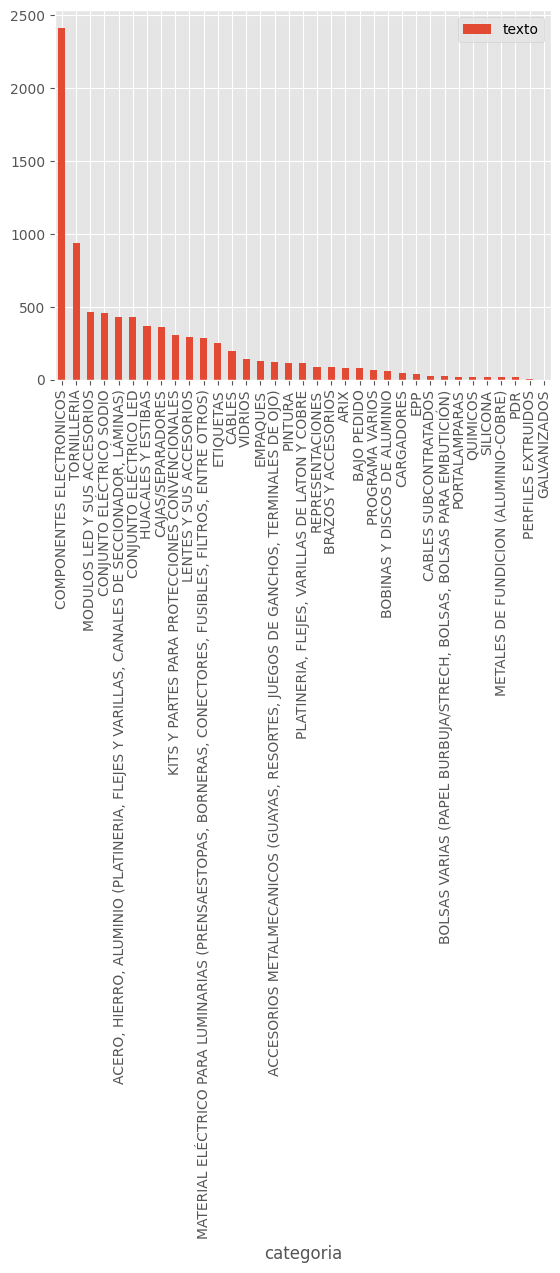

In [119]:
df.groupby('categoria').count().sort_values(by='texto', ascending=False).plot.bar(ylim=0)
plt.show() 

### **Stopwords y stemming**

escarga las stopwords (palabras vacías) del idioma, stas palabras son comunes y no suelen tener valor semántico para tareas de aprendizaje automático o análisis de texto. Ejemplos: "de", "la", "el", "y".

Crea un Snowball Stemmer para el idioma español.
Un lematizador es una herramienta para reducir las palabras a su raíz o forma base (stem).
Ejemplo: "corriendo", "corrió", "corre" → "corr".
La librería Snowball admite múltiples idiomas, y aquí se especifica que se usará el español.

In [8]:
import nltk
nltk.download('stopwords')

#Stopwords

spanish_stopwords = stopwords.words('spanish') + list(punctuation)

#stemming
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\afonseca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Creacion de bolsa de palabras**

In [9]:
vectorizer = TfidfVectorizer(sublinear_tf=True   # plica una transformación logarítmica suavizada a las frecuencias de términos


                             , min_df=5    # Ignora los términos que aparecen en menos de 5 documentos.
                             , encoding='latin-1'  # Especifica la codificación de los textos para manejar caracteres especiales correctamente.
                             , ngram_range=(1, 3)  # Considere no solo palabras individuales ( unigramas ), sino también combinaciones de 2 ( bigramas ) y 3 palabras consecutivas ( trigramas ). Esto captura contexto adicional.
                             , stop_words=spanish_stopwords  # Excluye palabras comunes en español (como "y", "de", "el", etc.)

                       )

In [11]:
features = vectorizer.fit_transform(df.texto)
labels = df['categoria']
features.shape

(8547, 2387)

Un vectorizer tiene todas las palabras del español por defecto. Su vocabulario se construye únicamente a partir del texto que se le proporciona durante el ajuste ( fito fit_transform). Es decir, el vectorizador aprenderá únicamente las palabras presentes en el conjunto de datos que estás procesando. Si deseas incluir todas las palabras en español, tendrás que proporcionarle explícitamente un vocabulario predefinido.

In [12]:
terms = vectorizer.get_feature_names_out() # Use get_feature_names_out() instead of get_feature_names() # Obtiene la lista de términos únicos que el TfidfVectorizerha aprendido durante el ajuste

doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(features)] # Itera sobre cada fila de features

In [13]:
dv = pd.DataFrame(data=features.toarray(), index=doc_names, columns=terms)

Combina la columna Topicdel conjunto de datos original ( df) con la matriz TF-IDF ( dv), creando un DataFrame completo que incluye las etiquetas del documento junto con los pesos TF-IDF de cada término.

### MODELAR 

**CROSS VALIDATION** 

In [125]:
cv=10

In [126]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=21),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=1)
]

In [127]:
cv_df = pd.DataFrame(index=range(cv * len(models)))
entries = []

In [128]:

#Cross-validation: 10-folds
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [129]:
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LinearSVC                     0.920196
LogisticRegression            0.905458
GradientBoostingClassifier    0.893526
MultinomialNB                 0.865213
RandomForestClassifier        0.773134
KNeighborsClassifier          0.747621
Name: accuracy, dtype: float64

In [130]:
modelo = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)
modelo.fit(X_train, y_train)

LinearSVC()

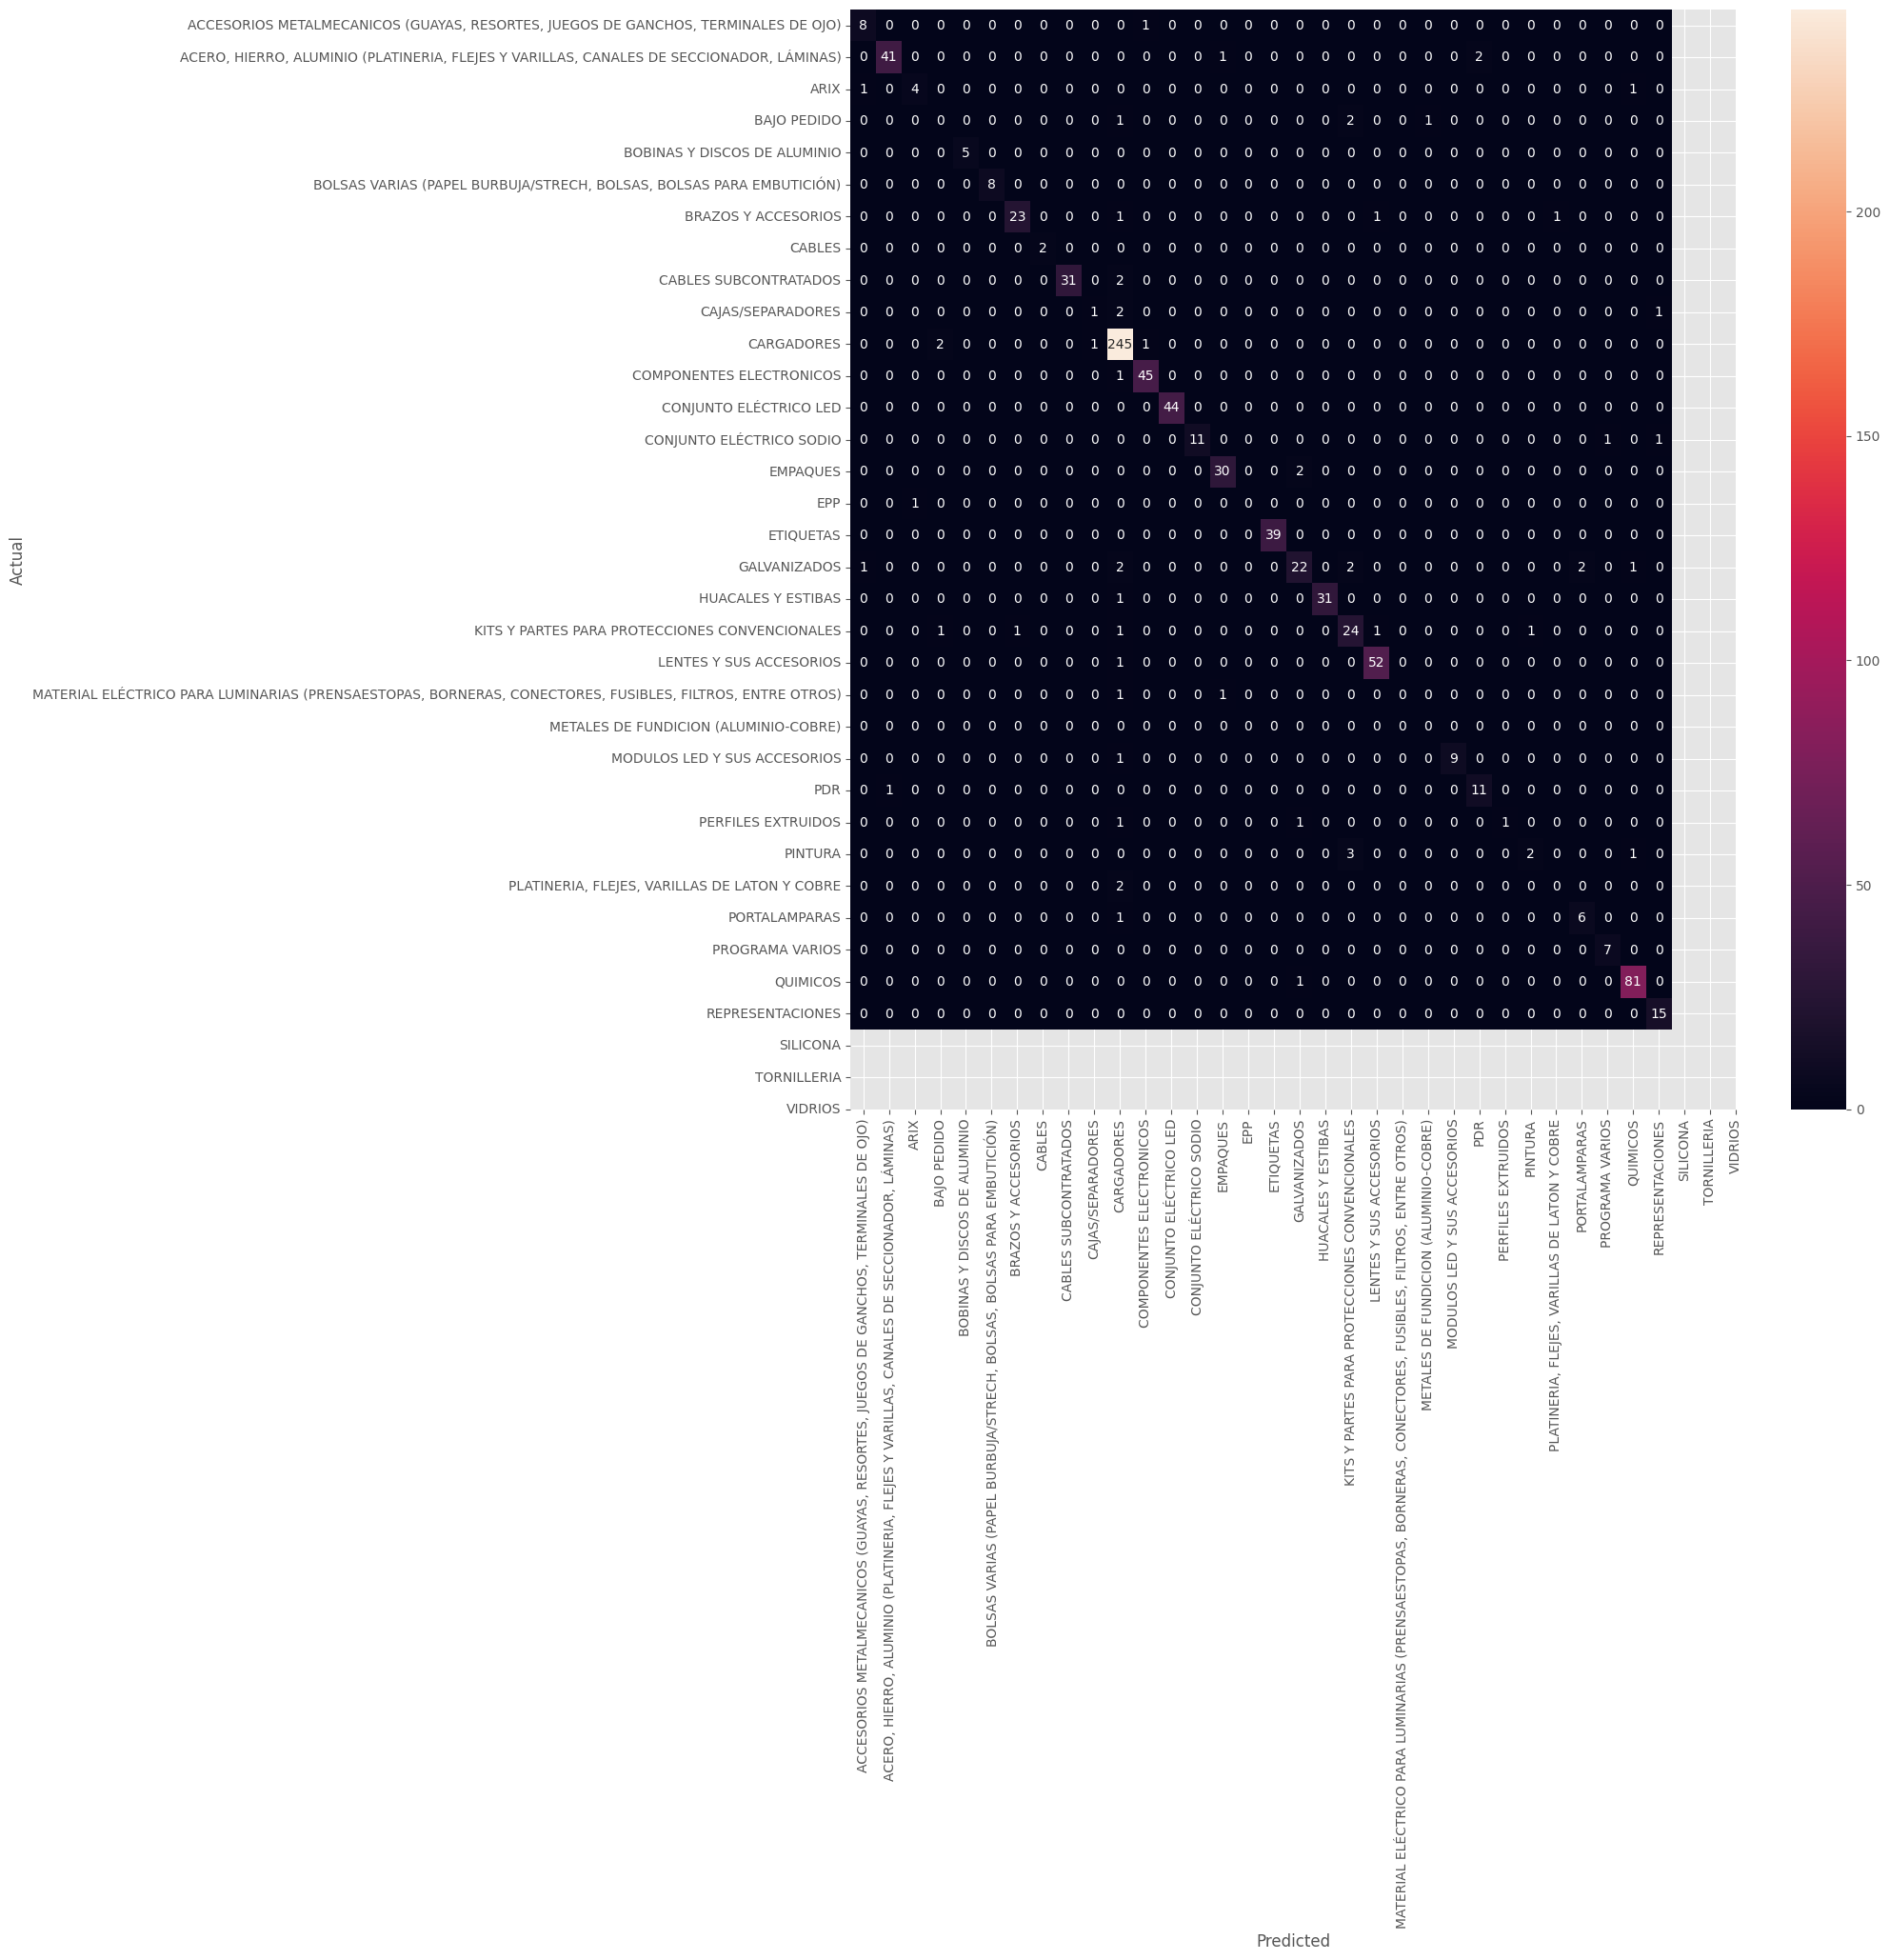

                                                                                                          precision    recall  f1-score   support

                      ACCESORIOS METALMECANICOS (GUAYAS, RESORTES, JUEGOS DE GANCHOS, TERMINALES DE OJO)       0.80      0.89      0.84         9
                ACERO, HIERRO, ALUMINIO (PLATINERIA, FLEJES Y VARILLAS, CANALES DE SECCIONADOR, LÁMINAS)       0.98      0.93      0.95        44
                                                                                                    ARIX       0.80      0.67      0.73         6
                                                                                             BAJO PEDIDO       0.00      0.00      0.00         4
                                                                            BOBINAS Y DISCOS DE ALUMINIO       1.00      1.00      1.00         5
                                                                                     BRAZOS Y ACCESORIOS       1.00      1.

In [131]:
#Matriz de confusión

y_pred = modelo.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=df['categoria'].sort_values().unique()
            , yticklabels=df['categoria'].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred))

### APLICAR MODELO LinearSVC

In [138]:
modelo_=LinearSVC()

In [139]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)
modelo_.fit(X_train, y_train)

LinearSVC()

guardar modelo 

In [145]:
import joblib
import os

# Ruta local donde guardarás el modelo
ruta_directorio = r"C:\Users\afonseca\Documents\texto"
nombre_archivo = "modelTextSVC.pkl"
ruta_completa = os.path.join(ruta_directorio, nombre_archivo)

# Verifica si el directorio existe; si no, lo crea
if not os.path.exists(ruta_directorio):
    os.makedirs(ruta_directorio)

# Guarda el modelo en la ruta completa
joblib.dump(modelo_, ruta_completa)

print(f"Modelo guardado correctamente en {ruta_completa}")


Modelo guardado correctamente en C:\Users\afonseca\Documents\texto\modelTextSVC.pkl


cargar modelo 

In [15]:
import joblib
import os

# Ruta completa donde se encuentra el modelo guardado
ruta_modelo = r"C:\Users\afonseca\Documents\texto\modelTextSVC.pkl"

# Verifica si el archivo existe antes de cargarlo
if os.path.exists(ruta_modelo):
    modelo_cargado = joblib.load(ruta_modelo)
    print("Modelo cargado correctamente.")
else:
    print(f"El archivo no existe en la ruta especificada: {ruta_modelo}")

Modelo cargado correctamente.


In [32]:
def queryCategory(query):
 
    texts = [query]
    text_features = vectorizer.transform(texts)
    p=text_features.nonzero()[0]
    
    if p.size== 0:
        predictions =  []
    else:
        predictionsId = modelo_cargado.predict(text_features)[0]
        #predictionsId = np.append(predictionsId, modelo_cargado.predict(text_features))
        
         
        predictions = [predictionsId]
    
    return print(f' la prediccion de categoria es {predictions}')

prediccion de categoria 

In [37]:
queryCategory("huacal de madera 3x3 para exportacion de tornillo")

 la prediccion de categoria es ['HUACALES Y ESTIBAS']
